<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gut-Check---All-U2P-net-revenue-forecast" data-toc-modified-id="Gut-Check---All-U2P-net-revenue-forecast-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gut Check - All U2P net revenue forecast</a></span><ul class="toc-item"><li><span><a href="#Revenue-from-non-SEM-joins-(any-time-through-2020)" data-toc-modified-id="Revenue-from-non-SEM-joins-(any-time-through-2020)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Revenue from non-SEM joins (any time through 2020)</a></span></li><li><span><a href="#Revenue-from-non-SEM-joins-(any-time-through-2021)" data-toc-modified-id="Revenue-from-non-SEM-joins-(any-time-through-2021)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Revenue from non-SEM joins (any time through 2021)</a></span></li><li><span><a href="#Revenue-from-<-2020-Joins-via-SEM" data-toc-modified-id="Revenue-from-<-2020-Joins-via-SEM-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Revenue from &lt; 2020 Joins via SEM</a></span></li><li><span><a href="#Revenue-from-<-2021-Joins-via-SEM" data-toc-modified-id="Revenue-from-<-2021-Joins-via-SEM-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Revenue from &lt; 2021 Joins via SEM</a></span></li><li><span><a href="#Revenue-forecast-weekly-rev-thru-2021" data-toc-modified-id="Revenue-forecast-weekly-rev-thru-2021-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Revenue forecast weekly rev thru 2021</a></span></li></ul></li></ul></div>

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from prophet import Prophet
import itertools
import json

import psycopg2
import pandas.io.sql as sqlio

from datetime import datetime
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# fix df.plot(x='',y='')
pd.plotting.register_matplotlib_converters()

import bamboolib as bam
bam.enable()

Success: the bamboolib extension was enabled successfully. You can disable it via 'bam.disable()'. You will now see a magic bamboolib button when you display your dataframes, for example via 'df'


In [2]:
def get_rs_creds():
    try:
        creds = !ssh etl-prod01 'cat .creds.json'
        creds = json.loads(''.join(creds))
        return creds
    except Exception as e:
        print(e)
        return None
    
def exec_rs_query_to_df(query, data=None):
    try:
        creds = get_rs_creds()
        
        con = psycopg2.connect(**creds)
        return sqlio.read_sql_query(query, con, params=data)
    
    except Exception as e:
        print(e)
        return

# Gut Check - All U2P net revenue forecast

In [3]:
query='''
SELECT
    DATE_TRUNC('day', pl.created_at AT TIME ZONE 'america/los_angeles') AS ds,
    SUM(pl.amount_usd) AS y
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS p ON p.id = pl.payment_id
WHERE 1=1
    AND pl.created_at >= '2018-01-01'
    AND pl.created_at < DATE(GETDATE() AT TIME ZONE 'UTC' AT TIME ZONE 'America/Los_Angeles') AT TIME ZONE 'America/Los_Angeles' AT TIME ZONE 'UTC' 
    AND p.site_id IN (1,12)
GROUP BY 1
ORDER BY 1
'''


In [4]:
# Query redshift for data -> store to df
# df = exec_rs_query_to_df(query)

In [6]:
# Save df as CSV
# df.to_csv('./data/daily_rev_2018_to_2021-10-14.csv', index=False)

In [7]:
# Load existing data as dataframe
df = pd.read_csv('./data/daily_rev_2018_to_2021-10-14.csv')

In [8]:
df

ds          y
0     2017-12-31   33954.62
1     2018-01-01  150058.53
2     2018-01-02  182843.90
3     2018-01-03  166454.29
4     2018-01-04  164656.84
...          ...        ...
1378  2021-10-09  265601.49
1379  2021-10-10  260725.79
1380  2021-10-11  271151.62
1381  2021-10-12  295372.16
1382  2021-10-13  263497.78

[1383 rows x 2 columns]

In [9]:
# Drop first and last entries
df.sort_values('ds', inplace=True)

# Drop most recent entry (incomplete)
df = df.reset_index(drop=True)
df = df.drop(max(df.index))
df = df.drop(0)

In [10]:
# remove outliers
df.loc[(df.ds > '2020-02-10') & (df.ds < '2020-07-10'), 'y'] = None
df.loc[(df.ds >= '2018-05-21') & (df.ds <= '2018-05-24'), 'y'] = None

<AxesSubplot:xlabel='ds'>

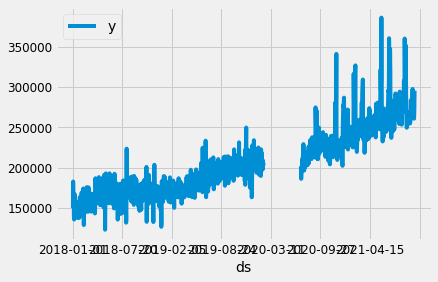

In [11]:
df.plot(x='ds',y='y')

In [12]:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
# future = model.make_future_dataframe(periods=128, freq='W-MON')
future = model.make_future_dataframe(periods=800, freq='D')
future.ds = future.ds.apply(lambda x: x.replace(minute=0, second=0, hour=0).strftime("%Y-%m-%d %H:%M:%S"))
future.head()

ds
0  2018-01-01 00:00:00
1  2018-01-02 00:00:00
2  2018-01-03 00:00:00
3  2018-01-04 00:00:00
4  2018-01-05 00:00:00

In [14]:
forecast = model.predict(future)

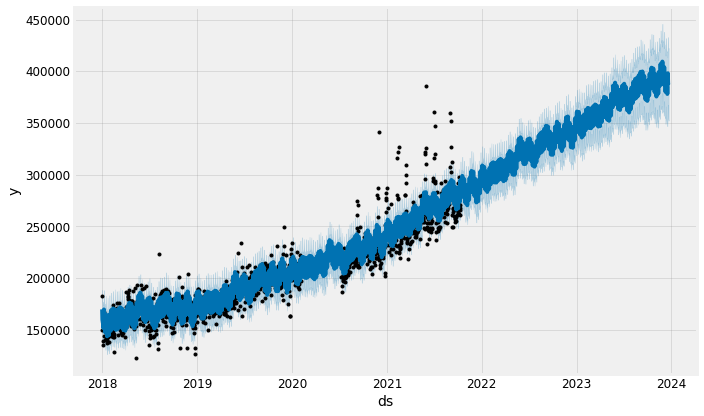

In [15]:
fig1 = model.plot(forecast)

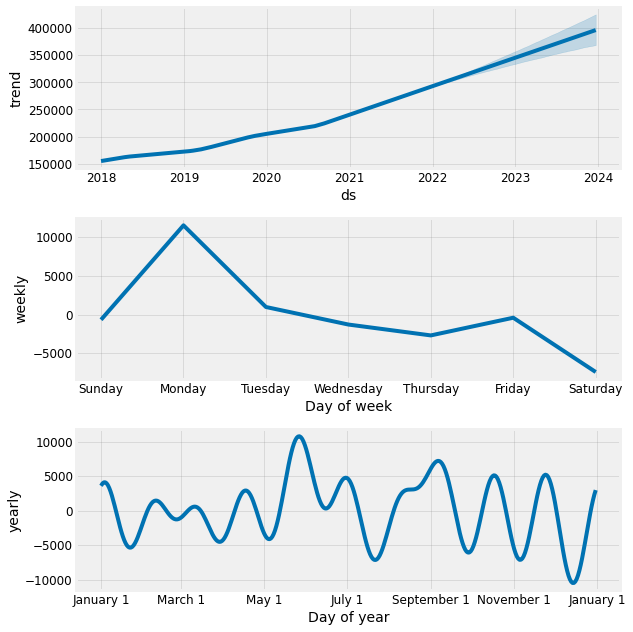

In [16]:
fig2 = model.plot_components(forecast)

In [17]:
# 2021
print("LOWER:", sum(forecast[(forecast.ds > '2020-12-31') & (forecast.ds <= '2021-12-31')].yhat_lower))
print("MIDDLE:", sum(forecast[(forecast.ds > '2020-12-31') & (forecast.ds <= '2021-12-31')].yhat))
print("UPPER:", sum(forecast[(forecast.ds > '2020-12-31') & (forecast.ds <= '2021-12-31')].yhat_upper))


LOWER: 90684131.51839115
MIDDLE: 97329356.9885969
UPPER: 103961222.6361971


In [18]:
# 2022
print("LOWER:", sum(forecast[(forecast.ds > '2021-12-31') & (forecast.ds <= '2022-12-31')].yhat_lower))
print("MIDDLE:", sum(forecast[(forecast.ds > '2021-12-31') & (forecast.ds <= '2022-12-31')].yhat))
print("UPPER:", sum(forecast[(forecast.ds > '2021-12-31') & (forecast.ds <= '2022-12-31')].yhat_upper))

LOWER: 109525621.5694092
MIDDLE: 116513596.19111907
UPPER: 123616978.6235646


## Revenue from non-SEM joins (any time through 2020)
Used to predict a sum of net revenue for 2020 from members who joined through all non-SEM channels at any time thru 2020.

In [19]:
query='''
SELECT
  DATE_TRUNC('day', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS ds,
  -- SUM(CASE WHEN sap.id IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS y
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS y
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS b ON b.id = pl.payment_id
INNER JOIN u2p_sites.customers AS c ON c.id = b.customer_id
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.user_id = c.account_id
  AND b.site_id = 1
  AND NOT (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')

LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id
  AND b.site_id = 12
  AND NOT (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.profiles AS wypp ON wypp.account_id = wypa.id

WHERE 1=1
  AND b.site_id = 1
  AND pl.created_at >= '2017-12-31 08:00:00' 
  AND pl.created_at < DATE(GETDATE() AT TIME ZONE 'UTC' AT TIME ZONE 'America/Los_Angeles') AT TIME ZONE 'America/Los_Angeles' AT TIME ZONE 'UTC' 
GROUP BY 1 
'''

In [20]:
# # Query Redshift to get daily data
# df = exec_rs_query_to_df(query)
# df

ds          y
0    2018-03-31  113133.85
1    2018-04-14  124334.90
2    2018-07-12  115351.28
3    2018-08-20  146832.99
4    2018-08-24  137214.33
...         ...        ...
1378 2021-04-07  174498.48
1379 2021-05-26  189928.85
1380 2021-06-09  188556.42
1381 2021-06-20  188239.04
1382 2021-09-21  196210.43

[1383 rows x 2 columns]

In [25]:
# Optionally save df as CSV
# df.to_csv('./data/organic_from_2018.csv', index=False)


In [27]:
# Optionally load df from CSV
df = pd.read_csv('./data/organic_from_2018.csv')

In [28]:
# df = pd.read_csv('./no_refer_rev.csv', names=['ds','y'], header=1, parse_dates=True)

# Drop first and last entries
df.sort_values('ds', inplace=True)

# Drop most recent entry (incomplete)
df = df.reset_index(drop=True)
df = df.drop(max(df.index))

df.head()

ds          y
0  2017-12-31   95431.53
1  2018-01-01  121881.01
2  2018-01-02  146845.98
3  2018-01-03  134041.33
4  2018-01-04  129693.48

In [29]:
df_orig = df.copy()

In [30]:
# remove outliers
df.loc[(df.ds > '2020-02-10') & (df.ds < '2020-07-10'), 'y'] = None
df.loc[(df.ds >= '2018-05-21') & (df.ds <= '2018-05-24'), 'y'] = None

<AxesSubplot:xlabel='ds'>

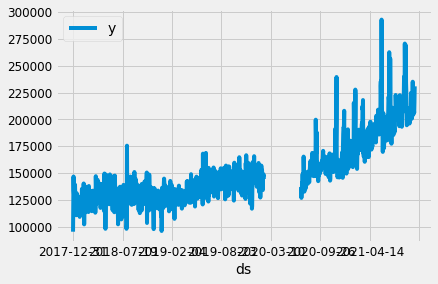

In [31]:
df.plot(x='ds',y='y')


In [32]:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
# future = model.make_future_dataframe(periods=128, freq='W-MON')
future = model.make_future_dataframe(periods=800, freq='D')
future.ds = future.ds.apply(lambda x: x.replace(minute=0, second=0, hour=0).strftime("%Y-%m-%d %H:%M:%S"))
future.head()

ds
0  2017-12-31 00:00:00
1  2018-01-01 00:00:00
2  2018-01-02 00:00:00
3  2018-01-03 00:00:00
4  2018-01-04 00:00:00

In [34]:
forecast = model.predict(future)

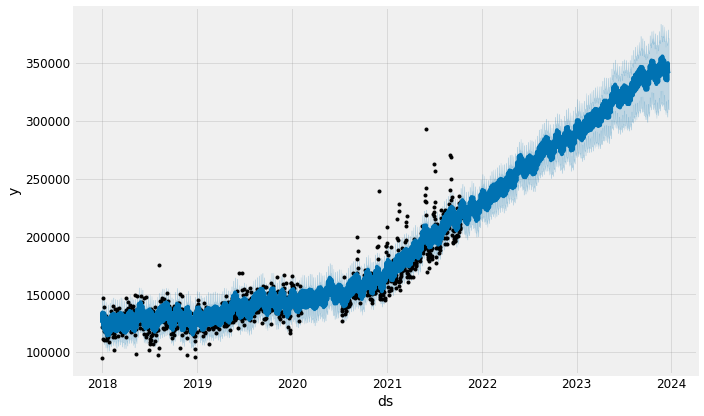

In [35]:
fig1 = model.plot(forecast)

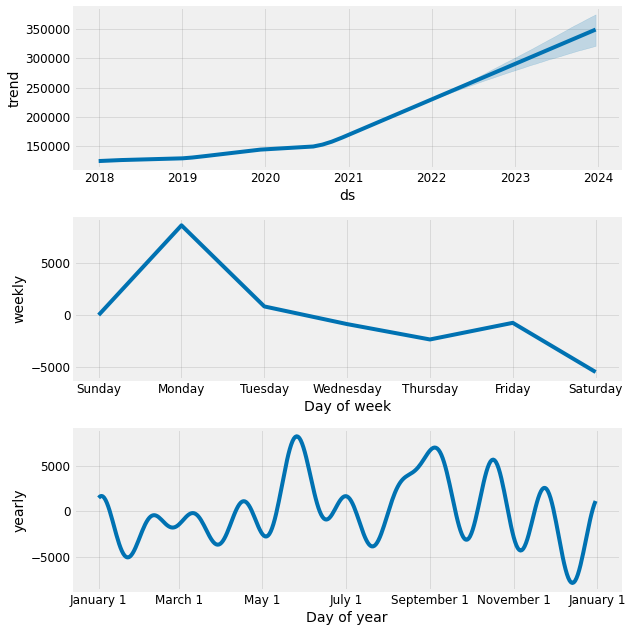

In [36]:
fig2 = model.plot_components(forecast)

In [37]:
forecast.tail()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
2177 2023-12-17  348415.482722  309804.441030  369670.455006  320856.275402   
2178 2023-12-18  348581.382043  318613.174757  379162.907233  320968.604129   
2179 2023-12-19  348747.281364  311192.310563  371650.759321  321080.932855   
2180 2023-12-20  348913.180686  310288.329397  371730.048572  321193.261582   
2181 2023-12-21  349079.080007  310009.379437  371722.779923  321314.421272   

        trend_upper  additive_terms  additive_terms_lower  \
2177  374309.939252    -7540.694544          -7540.694544   
2178  374499.855554     1417.050055           1417.050055   
2179  374689.771856    -5919.696164          -5919.696164   
2180  374879.688157    -7076.909858          -7076.909858   
2181  375065.754664    -7937.853589          -7937.853589   

      additive_terms_upper       weekly  weekly_lower  weekly_upper  \
2177          -7540.694544     0.708665      0.708665      0.708665   
2178           1417.050055  8611.269127   8611.269127   8611.269127   
2179          -5919.696164   825.396889    825.396889    825.396889   
2180          -7076.909858  -870.821663   -870.821663   -870.821663   
2181          -7937.853589 -2346.451842  -2346.451842  -2346.451842   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
2177 -7541.403209  -7541.403209  -7541.403209                   0.0   
2178 -7194.219072  -7194.219072  -7194.219072                   0.0   
2179 -6745.093054  -6745.093054  -6745.093054                   0.0   
2180 -6206.088195  -6206.088195  -6206.088195                   0.0   
2181 -5591.401747  -5591.401747  -5591.401747                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper           yhat  
2177                         0.0                         0.0  340874.788179  
2178                         0.0                         0.0  349998.432098  
2179                         0.0                         0.0  342827.585200  
2180                         0.0                         0.0  341836.270827  
2181                         0.0                         0.0  341141.226417

In [38]:
# 2020
print("LOWER:", sum(forecast[(forecast.ds > '2019-12-31') & (forecast.ds <= '2020-12-31')].yhat_lower))
print("MIDDLE:", sum(forecast[(forecast.ds > '2019-12-31') & (forecast.ds <= '2020-12-31')].yhat))
print("UPPER:", sum(forecast[(forecast.ds > '2019-12-31') & (forecast.ds <= '2020-12-31')].yhat_upper))


LOWER: 50511178.3504676
MIDDLE: 55428777.6565567
UPPER: 60346073.61312588


In [39]:
# 2021
print("LOWER:", sum(forecast[(forecast.ds > '2020-12-31') & (forecast.ds <= '2021-12-31')].yhat_lower))
print("MIDDLE:", sum(forecast[(forecast.ds > '2020-12-31') & (forecast.ds <= '2021-12-31')].yhat))
print("UPPER:", sum(forecast[(forecast.ds > '2020-12-31') & (forecast.ds <= '2021-12-31')].yhat_upper))


LOWER: 67896653.5968683
MIDDLE: 72793816.25936225
UPPER: 77689899.64084877


In [40]:
# 2022
print("LOWER:", sum(forecast[(forecast.ds > '2021-12-31') & (forecast.ds <= '2022-12-31')].yhat_lower))
print("MIDDLE:", sum(forecast[(forecast.ds > '2021-12-31') & (forecast.ds <= '2022-12-31')].yhat))
print("UPPER:", sum(forecast[(forecast.ds > '2021-12-31') & (forecast.ds <= '2022-12-31')].yhat_upper))

LOWER: 89485214.02911265
MIDDLE: 94890986.30183347
UPPER: 100215963.74755754


In [47]:
print("2018:", sum(df[(df.ds >= '2018-01-01') & (df.ds < '2019-01-01')].y))


2018: nan


In [48]:
print("2019:", sum(forecast[(forecast.ds >= '2019-01-01') & (forecast.ds < '2020-01-01')].yhat))


2019: 49867230.0814136


In [49]:
sum(forecast[(forecast.ds >= '2018-01-01') & (forecast.ds < '2019-01-01')].yhat)

46349852.417022936

In [50]:
sum(df[(df.ds >= '2018-01-01') & (df.ds < '2019-01-01')].y)

nan

## Revenue from non-SEM joins (any time through 2021)
Used to predict a sum of net revenue for 2020 from members who joined through all non-SEM channels at any time thru 2021.

In [2]:
df = pd.read_csv('./no_refer_rev.csv', names=['ds','y'], header=1, parse_dates=True)
df.sort_values('ds', inplace=True)
df.drop(0, inplace=True)
df = df.reset_index(drop=True)
df.head()

ds          y
0  2017-12-24 16:00:00   97800.37
1  2017-12-31 16:00:00  891825.28
2  2018-01-07 16:00:00  877860.28
3  2018-01-14 16:00:00  844680.99
4  2018-01-21 16:00:00  846284.27

In [3]:
df.drop(0, inplace=True)

In [4]:
datetime.strptime(df.ds.iloc[0], '%Y-%m-%d %H:%M:%S').replace(minute=0, second=0, hour=0).strftime("%Y-%m-%d %H:%M:%S")

'2017-12-31 00:00:00'

In [5]:
df.ds = df.ds.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').replace(minute=0, second=0, hour=0).strftime("%Y-%m-%d %H:%M:%S"))
df.head()

ds          y
1  2017-12-31 00:00:00  891825.28
2  2018-01-07 00:00:00  877860.28
3  2018-01-14 00:00:00  844680.99
4  2018-01-21 00:00:00  846284.27
5  2018-01-28 00:00:00  855306.72

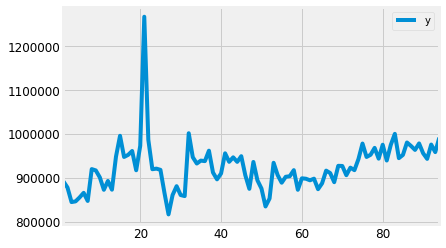

In [6]:
df.plot()


In [7]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=116, freq='W-MON')
future.ds = future.ds.apply(lambda x: x.replace(minute=0, second=0, hour=0).strftime("%Y-%m-%d %H:%M:%S"))
future.tail()

ds
205  2021-11-29 00:00:00
206  2021-12-06 00:00:00
207  2021-12-13 00:00:00
208  2021-12-20 00:00:00
209  2021-12-27 00:00:00

In [10]:
forecast = model.predict(future)

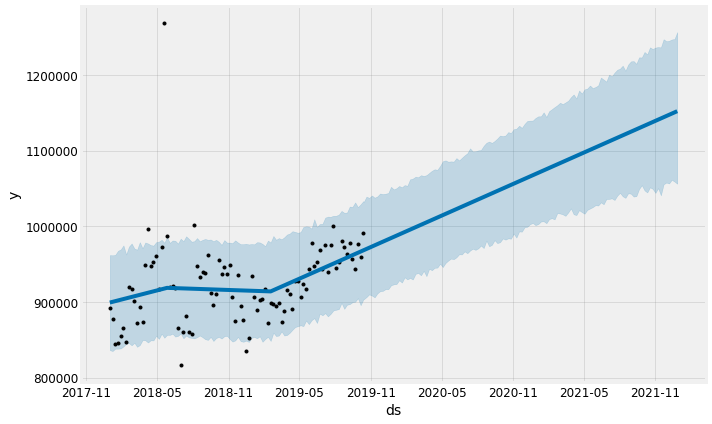

In [11]:
fig1 = model.plot(forecast)

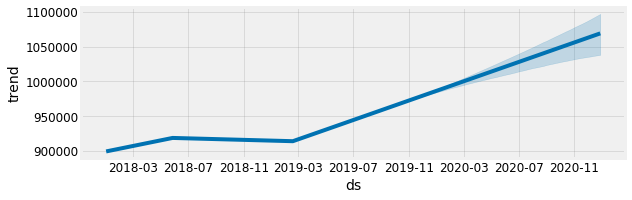

In [164]:
fig2 = model.plot_components(forecast)

In [12]:
forecast.tail()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
205 2021-11-29  1.145663e+06  1.057775e+06  1.244499e+06  1.080349e+06   
206 2021-12-06  1.147260e+06  1.056571e+06  1.245050e+06  1.080748e+06   
207 2021-12-13  1.148856e+06  1.061414e+06  1.246789e+06  1.081495e+06   
208 2021-12-20  1.150453e+06  1.059073e+06  1.247429e+06  1.082383e+06   
209 2021-12-27  1.152050e+06  1.056237e+06  1.256518e+06  1.083194e+06   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
205  1.218425e+06             0.0                   0.0                   0.0   
206  1.221158e+06             0.0                   0.0                   0.0   
207  1.223501e+06             0.0                   0.0                   0.0   
208  1.226042e+06             0.0                   0.0                   0.0   
209  1.228584e+06             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
205                   0.0                         0.0   
206                   0.0                         0.0   
207                   0.0                         0.0   
208                   0.0                         0.0   
209                   0.0                         0.0   

     multiplicative_terms_upper          yhat  
205                         0.0  1.145663e+06  
206                         0.0  1.147260e+06  
207                         0.0  1.148856e+06  
208                         0.0  1.150453e+06  
209                         0.0  1.152050e+06

In [13]:
print("LOWER:", sum(forecast[forecast.ds > '2020-12-31'].yhat_lower))
print("MIDDLE:", sum(forecast[forecast.ds > '2020-12-31'].yhat))
print("UPPER:", sum(forecast[forecast.ds > '2020-12-31'].yhat_upper))


LOWER: 53677696.36668631
MIDDLE: 57789441.67778383
UPPER: 62284800.05736031


In [18]:
sum(forecast[(forecast.ds >= '2018-10-01') & (forecast.ds < '2019-10-01')].yhat)

48391091.12168058

In [19]:
sum(df[(df.ds >= '2018-10-01') & (df.ds < '2019-10-01')].y)

48189160.440000005

## Revenue from < 2020 Joins via SEM
Used to get a predicted Dec, 2019 revenue figure, which is input into a revenue decay model here: https://docs.google.com/spreadsheets/d/13Mj0mr6MW1anD_KyYDEUeBN54J_1YT1Jt7wrqYfHx2I/edit?ts=5db73812#gid=145493031

SQL Query, for posterity:
``` mysql
SELECT
  DATE_TRUNC('month', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS mnth,
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS revenue_ref
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS b ON b.id = pl.payment_id
INNER JOIN u2p_sites.customers AS c ON c.id = b.customer_id
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.id = c.account_id
  AND b.site_id = 1
  AND (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id
  AND b.site_id = 12
  AND (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.profiles AS wypp ON wypp.account_id = wypa.id
WHERE 1=1
  AND pl.created_at >= '2017-12-31 08:00:00' 
GROUP BY 1 
```

In [122]:
query='''
SELECT
  DATE_TRUNC('month', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS mnth,
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS revenue_ref
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS b ON b.id = pl.payment_id
INNER JOIN u2p_sites.customers AS c ON c.id = b.customer_id
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.id = c.account_id
  AND b.site_id = 1
  AND (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id
  AND b.site_id = 12
  AND (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.profiles AS wypp ON wypp.account_id = wypa.id
WHERE 1=1
  AND pl.created_at >= '2017-12-31 08:00:00' 
GROUP BY 1 
'''

In [144]:
df = exec_rs_query_to_df(query)
df

mnth  revenue_ref
0  2018-04-01   1068662.91
1  2018-09-01   1125755.00
2  2019-05-01   1540255.96
3  2018-02-01    903823.32
4  2020-10-01   1819214.05
5  2020-06-01   2032013.63
6  2018-05-01   1076428.43
7  2019-04-01   1401725.48
8  2020-01-01   2077793.08
9  2018-03-01   1033127.87
10 2020-04-01   1730975.30
11 2018-10-01   1188015.22
12 2019-11-01   1973074.65
13 2020-05-01   1869944.00
14 2019-09-01   1849697.49
15 2020-08-01   2161014.59
16 2018-11-01   1219277.61
17 2020-02-01   1983599.44
18 2019-02-01   1279594.26
19 2020-03-01   1864295.55
20 2018-08-01   1218971.84
21 2020-07-01   1984304.20
22 2018-12-01   1244467.34
23 2019-03-01   1419720.27
24 2020-09-01   2164393.53
25 2017-12-01     20806.17
26 2019-01-01   1374867.49
27 2019-12-01   2030014.44
28 2018-01-01    908937.46
29 2018-06-01   1184283.26
30 2019-08-01   1792840.16
31 2019-10-01   1936779.51
32 2018-07-01   1170121.75
33 2019-06-01   1621581.73
34 2019-07-01   1696423.07

In [145]:
df = df.rename(columns={'mnth':'ds','revenue_ref':'y'})

In [146]:
# df = pd.read_csv('./refer_rev.csv', names=['ds','y'], header=1, parse_dates=True)
df.sort_values('ds', inplace=True)
df = df.reset_index(drop=True)
df.drop(0, inplace=True)
df.drop(max(df.index), inplace=True)
df.tail()

ds           y
29 2020-05-01  1869944.00
30 2020-06-01  2032013.63
31 2020-07-01  1984304.20
32 2020-08-01  2161014.59
33 2020-09-01  2164393.53

In [147]:
# Drop outliers
df.loc[(df.ds >= '2020-03-01')& (df.ds < '2020-06-01'), 'y'] = None

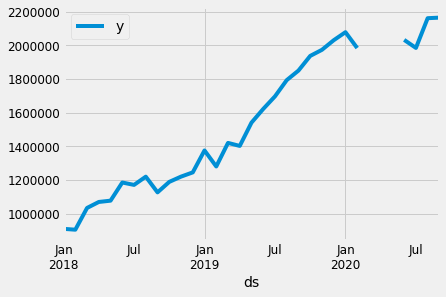

In [148]:
df.plot(x='ds',y='y')

In [149]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


In [150]:
future = model.make_future_dataframe(periods=12, freq='MS')
future.tail(12)

ds
33 2020-10-01
34 2020-11-01
35 2020-12-01
36 2021-01-01
37 2021-02-01
38 2021-03-01
39 2021-04-01
40 2021-05-01
41 2021-06-01
42 2021-07-01
43 2021-08-01
44 2021-09-01

In [151]:
forecast = model.predict(future)

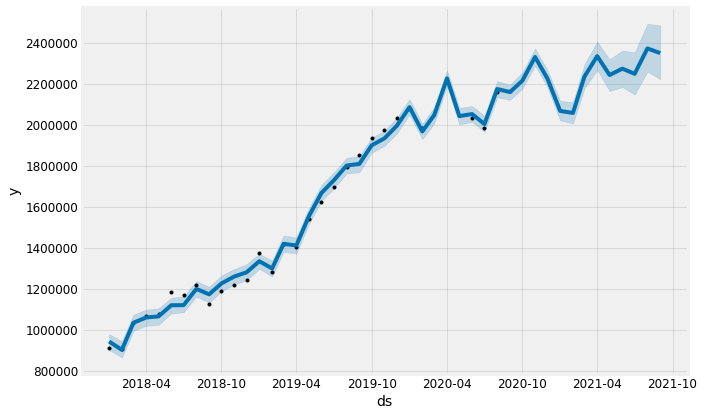

In [152]:
fig1 = model.plot(forecast)

In [153]:
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2018-01-01  1.030686e+06  9.015167e+05  9.789444e+05  1.030686e+06   
1 2018-02-01  1.050905e+06  8.639454e+05  9.426883e+05  1.050905e+06   
2 2018-03-01  1.069166e+06  9.944162e+05  1.073361e+06  1.069166e+06   
3 2018-04-01  1.089384e+06  1.018783e+06  1.098154e+06  1.089384e+06   
4 2018-05-01  1.108950e+06  1.023881e+06  1.103969e+06  1.108950e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  1.030686e+06   -88427.222447         -88427.222447         -88427.222447   
1  1.050905e+06  -149131.928428        -149131.928428        -149131.928428   
2  1.069166e+06   -35327.126062         -35327.126062         -35327.126062   
3  1.089384e+06   -29822.548059         -29822.548059         -29822.548059   
4  1.108950e+06   -44136.661992         -44136.661992         -44136.661992   

          yearly   yearly_lower   yearly_upper  multiplicative_terms  \
0  -88427.222447  -88427.222447  -88427.222447                   0.0   
1 -149131.928428 -149131.928428 -149131.928428                   0.0   
2  -35327.126062  -35327.126062  -35327.126062                   0.0   
3  -29822.548059  -29822.548059  -29822.548059                   0.0   
4  -44136.661992  -44136.661992  -44136.661992                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  9.422593e+05  
1                         0.0                         0.0  9.017727e+05  
2                         0.0                         0.0  1.033839e+06  
3                         0.0                         0.0  1.059562e+06  
4                         0.0                         0.0  1.064814e+06

In [157]:
int(forecast[forecast.ds=='2020-12-01'].yhat)

2224655

In [141]:
int(forecast[forecast.ds=='2019-12-01'].yhat)

TypeError: cannot convert the series to <class 'int'>

## Revenue from < 2021 Joins via SEM
Used to get a predicted Dec, 2019 revenue figure, which is input into a revenue decay model here: https://docs.google.com/spreadsheets/d/13Mj0mr6MW1anD_KyYDEUeBN54J_1YT1Jt7wrqYfHx2I/edit?ts=5db73812#gid=145493031

## Revenue forecast weekly rev thru 2021

In [17]:
df = pd.read_csv('./weekly_rev_2018_beyond.csv', names=['ds','y'], header=1, parse_dates=True)
df.sort_values('ds', inplace=True)
df = df.reset_index(drop=True)
df.drop(95, inplace=True)
df.head()

ds           y
0  2018-01-01 00:00:00  1099450.90
1  2018-01-08 00:00:00  1086460.93
2  2018-01-15 00:00:00  1035568.12
3  2018-01-22 00:00:00  1052917.12
4  2018-01-29 00:00:00  1080933.89

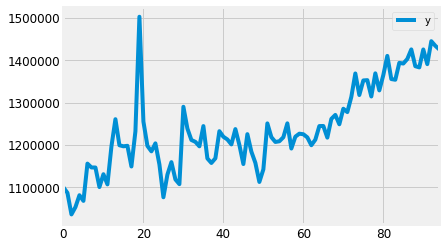

In [18]:
df.plot()

In [19]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = model.make_future_dataframe(periods=116, freq='W-MON')
future.tail()

ds
206 2021-12-20
207 2021-12-27
208 2022-01-03
209 2022-01-10
210 2022-01-17

In [21]:
forecast = model.predict(future)

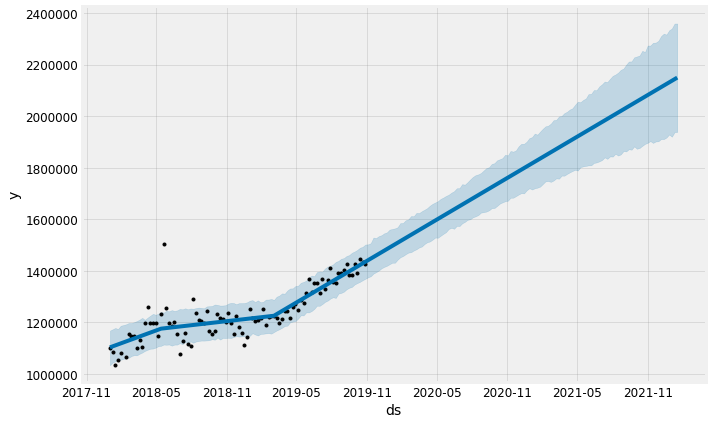

In [22]:
fig1 = model.plot(forecast)

In [23]:
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2018-01-01  1.103602e+06  1.034361e+06  1.168558e+06  1.103602e+06   
1 2018-01-08  1.107420e+06  1.044539e+06  1.173675e+06  1.107420e+06   
2 2018-01-15  1.111237e+06  1.049435e+06  1.178743e+06  1.111237e+06   
3 2018-01-22  1.115054e+06  1.052359e+06  1.174614e+06  1.115054e+06   
4 2018-01-29  1.118871e+06  1.055745e+06  1.187340e+06  1.118871e+06   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  1.103602e+06             0.0                   0.0                   0.0   
1  1.107420e+06             0.0                   0.0                   0.0   
2  1.111237e+06             0.0                   0.0                   0.0   
3  1.115054e+06             0.0                   0.0                   0.0   
4  1.118871e+06             0.0                   0.0                   0.0   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  1.103602e+06  
1                         0.0  1.107420e+06  
2                         0.0  1.111237e+06  
3                         0.0  1.115054e+06  
4                         0.0  1.118871e+06

In [24]:
forecast[forecast.ds == '2021-12-01 00:00:00']

Empty DataFrame
Columns: [ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat]
Index: []

In [32]:
print("2020 naive forecast: $" + str(round(sum(forecast[(forecast.ds >= '2019-12-31 00:00:00') & (forecast.ds < '2021-01-01 00:00:00')].yhat), 2)))
print("2021 naive forecast: $" + str(round(sum(forecast[(forecast.ds >= '2020-12-31 00:00:00') & (forecast.ds < '2022-01-01 00:00:00')].yhat), 2)))

2020 naive forecast: $86003500.75
2021 naive forecast: $102651131.11
